<h1>Clustering With HDBSCAN</h1>

Clustering analysis with HDBSCAN of a Spotify song dataset.

In [21]:
import pandas as pd
import seaborn as sns
import hdbscan
from sklearn.metrics import silhouette_score, silhouette_samples
from ipynb.fs.full.funPyModeling import status, cat_vars, freq_tbl, coord_plot

<h3>Data Loading</h3>

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv")

<h3>Dataset Status</h3>

In [3]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,track_id,0,0.000000,0,0.000000,28356,object
1,track_name,5,0.000152,0,0.000000,23449,object
2,track_artist,5,0.000152,0,0.000000,10692,object
3,track_popularity,0,0.000000,2703,0.082326,101,int64
4,track_album_id,0,0.000000,0,0.000000,22545,object
5,track_album_name,5,0.000152,0,0.000000,19743,object
6,track_album_release_date,0,0.000000,0,0.000000,4530,object
7,playlist_name,0,0.000000,0,0.000000,449,object
8,playlist_id,0,0.000000,0,0.000000,471,object
9,playlist_genre,0,0.000000,0,0.000000,6,object


There are NaNs in 'track_name', 'track_artist' and 'track_album_name'. Also, there are high cardinality variables, like 'track_name' and 'track_artist'.

<h3>Data Preparation</h3>

Remove duplicate songs

In [4]:
data = data.drop_duplicates(subset="track_id")

Remove categorical variables

In [5]:
x_data = data.drop(cat_vars(data), axis=1)

Remove other variables

In [6]:
x_data=x_data.drop(['key','speechiness', 'mode', 'tempo', 'duration_ms'], axis=1)

<h3>Models Creation</h3>

In [7]:
model_hdb = hdbscan.HDBSCAN()

Fitting the model

In [8]:
model_hdb.fit(x_data)

HDBSCAN()

Created clusters

In [9]:
freq_tbl(model_hdb.labels_)

,0,frequency,percentage,cumulative_perc
0,29,2606,0.091903,0.091903
1,-1,2527,0.089117,0.181020
2,30,526,0.018550,0.199570
3,93,433,0.015270,0.214840
4,71,431,0.015200,0.230039
...,...,...,...,...
166,17,5,0.000176,0.999295
167,10,5,0.000176,0.999471
168,53,5,0.000176,0.999647
169,130,5,0.000176,0.999824


There are 171 clusters, and some of them are -1 (noise clusters)

<h3>HDBSCAN tuning</h3>

Reduce of the numbers of clusters by selecting the minimum cluster size

In [10]:
model_hdb2 = hdbscan.HDBSCAN(min_cluster_size=80, prediction_data=True).fit(x_data)

In [11]:
freq_tbl(model_hdb2.labels_.astype('str'))

,0,frequency,percentage,cumulative_perc
0,0,14230,0.501834,0.501834
1,-1,11403,0.402137,0.903971
2,2,2411,0.085026,0.988997
3,1,312,0.011003,1.000000


Now, there are only 4 clusters, and one of them is a noise cluster

<h3>Cluster Analysis</h3>

In [12]:
cluster_var = 'cluster'
x_data_cl = x_data.copy()
x_data_cl[cluster_var] = model_hdb2.labels_

Remove the noise cluster

In [13]:
x_data_cl = x_data_cl[x_data_cl['cluster']!=-1]

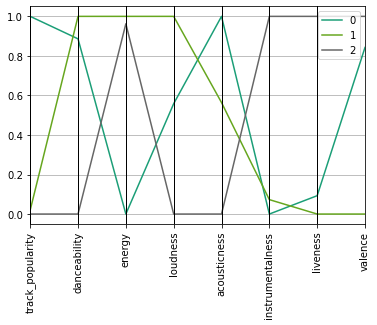

In [14]:
d_orig, d_transf = coord_plot(x_data_cl, cluster_var)

In [15]:
freq_tbl(x_data_cl['cluster'])

,cluster,frequency,percentage,cumulative_perc
0,0,14230,0.839379,0.839379
1,2,2411,0.142217,0.981596
2,1,312,0.018404,1.000000


From this analysis, i see than the tracks with the higher popularity are the one with the lowest energy and instrumentalness, and with the higher acousticness.

<h3>Silhouette Analysis</h3>

In [16]:
sil_avg = silhouette_score(x_data, model_hdb2.labels_)

sil_avg return the global mean

In [17]:
sil_avg

0.01367534290145299

Silhouette for every sample:

In [18]:
sample_silhouette_values = silhouette_samples(x_data, model_hdb2.labels_)

In [19]:
res_sil=pd.DataFrame({'sil_value': sample_silhouette_values, 'cluster': model_hdb2.labels_})

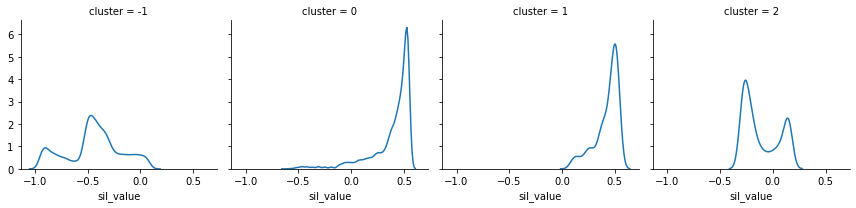

In [22]:
g = sns.FacetGrid(res_sil, col='cluster')
g = g.map(sns.kdeplot, 'sil_value')

From this graphics:
<li>The data in -1 cluster is not well classified, because the values are between 0 and -1</li>
<li>The data in the 0 cluster is not well classified, because the values are between -0.5 and 0.5, so the data is between 2 clusters</li>
<li>The data in the 1 cluster is not well classified, because the values are between 0 and 0.5, so the data is between 2 clusters</li>
<li>The data in the 2 cluster is not well classified, because the values are between -0.5 and 0.5, so the data is between 2 clusters</li>

Silhouette mean by cluster

In [23]:
res_sil.groupby('cluster').mean('sil_value')

,sil_value
cluster,
-1,-0.438277
0,0.387677
1,0.425971
2,-0.109539
